#Importing Necessary libraries



In [166]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [143]:

import kagglehub

dataset_path = kagglehub.dataset_download("uciml/sms-spam-collection-dataset")

print("Path to dataset files:", dataset_path)

df = pd.read_csv(f"{dataset_path}/spam.csv", encoding="latin1")
df = df.iloc[:, :2]
df.columns = ['label', 'message']




Path to dataset files: /root/.cache/kagglehub/datasets/uciml/sms-spam-collection-dataset/versions/1


# EDA




In [144]:
df.shape

(5572, 2)

In [145]:
df.columns

Index(['label', 'message'], dtype='object')

In [146]:
df.dtypes


,0
label,object
message,object


In [147]:
df.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [148]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    5572 non-null   object
 1   message  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [149]:
df.isnull().sum()

,0
label,0
message,0


In [150]:
df.describe(include='object')

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [151]:
#Encoding the target value
df['label'] = df['label'].map({'ham': 0, 'spam': 1})

In [152]:
df.head()

,label,message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


#Dataset Imbalance check

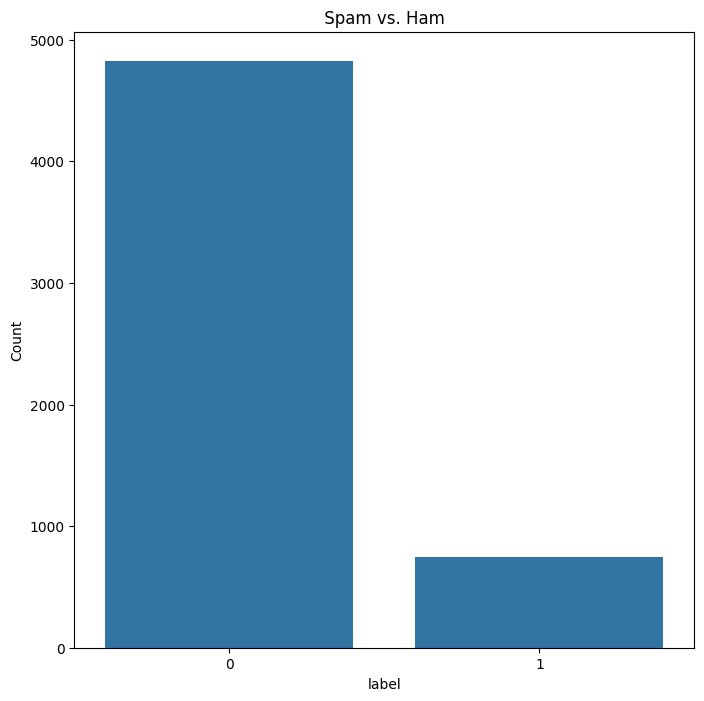

In [153]:
plt.figure(figsize=(8,8))
g = sns.countplot(x='label', data=df)
p = plt.title(' Spam vs. Ham ')
p = plt.ylabel('Count')

In [154]:
only_spam = df[df['label']==1]
print('Total Spam records: {}'.format(only_spam.shape[0]))
print('Total Ham records: {}'.format(df.shape[0]-only_spam.shape[0]))


Total Spam records: 747
Total Ham records: 4825


In [155]:
from sklearn.utils import resample

# Filter for spam (1) and ham (0)
only_spam = df[df['label'] == 1]
only_ham = df[df['label'] == 0]

# Perform oversampling of spam to match the number of ham records
only_spam_oversampled = resample(only_spam,
                                 replace=True,  # Sample with replacement
                                 n_samples=only_ham.shape[0],  # Match ham count
                                 random_state=42)

# Concatenate the oversampled spam with the ham records
df = pd.concat([only_ham, only_spam_oversampled])

# Print the new class distribution
print(df['label'].value_counts())


label
0    4825
1    4825
Name: count, dtype: int64


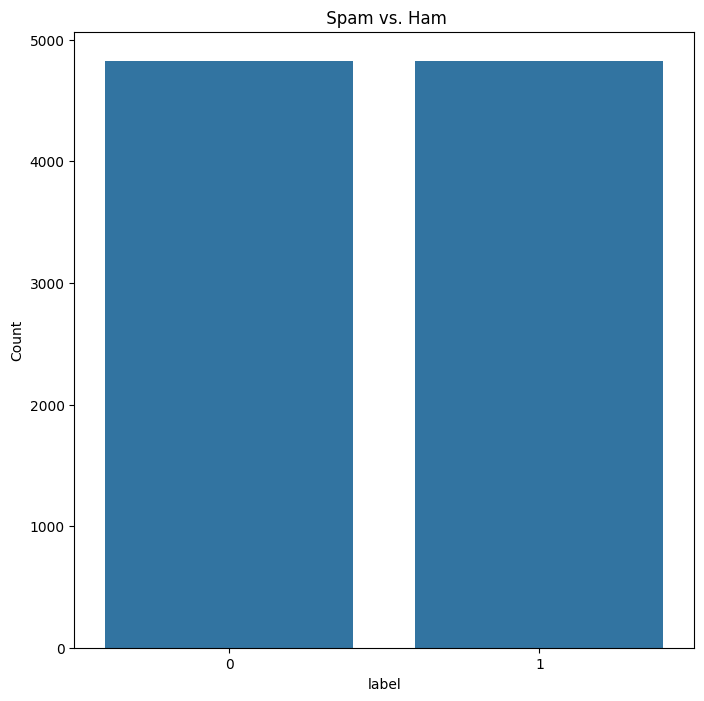

In [156]:
#  Spam vs. Ham as balanced dataset
plt.figure(figsize=(8,8))
g = sns.countplot(x='label', data=df)
p = plt.title(' Spam vs. Ham')
p = plt.ylabel('Count')

# **Feature Engineering**



In [157]:
import pandas as pd
import re

# Feature: Word Count
df['word_count'] = df['message'].apply(lambda x: len(x.split()))

# Feature: Contains Currency Symbol
currency_pattern = r'[€$¥£₹]'
df['contains_currency_symbol'] = df['message'].apply(lambda x: int(bool(re.search(currency_pattern, x))))

# Feature: Contains Number
df['contains_number'] = df['message'].apply(lambda x: int(any(c.isdigit() for c in x)))

# Feature: Message Length (Total Characters)
df['message_length'] = df['message'].apply(len)

# Feature: Uppercase Word Count
df['uppercase_word_count'] = df['message'].apply(lambda x: sum(1 for word in x.split() if word.isupper()))

# Feature: Special Character Count (!, %, #, etc.)
df['special_char_count'] = df['message'].apply(lambda x: sum(1 for char in x if not char.isalnum() and not char.isspace()))

# Display the first few rows with new features
print(df.head())


   label                                            message  word_count  \
0      0  Go until jurong point, crazy.. Available only ...          20   
1      0                      Ok lar... Joking wif u oni...           6   
3      0  U dun say so early hor... U c already then say...          11   
4      0  Nah I don't think he goes to usf, he lives aro...          13   
6      0  Even my brother is not like to speak with me. ...          16   

   contains_currency_symbol  contains_number  message_length  \
0                         0                0             111   
1                         0                0              29   
3                         0                0              49   
4                         0                0              61   
6                         0                0              77   

   uppercase_word_count  special_char_count  
0                     0                   9  
1                     0                   6  
3                     2   

In [158]:
df.head()

,label,message,word_count,contains_currency_symbol,contains_number,message_length,uppercase_word_count,special_char_count
0,0,"Go until jurong point, crazy.. Available only ...",20,0,0,111,0,9
1,0,Ok lar... Joking wif u oni...,6,0,0,29,0,6
3,0,U dun say so early hor... U c already then say...,11,0,0,49,2,6
4,0,"Nah I don't think he goes to usf, he lives aro...",13,0,0,61,1,2
6,0,Even my brother is not like to speak with me. ...,16,0,0,77,0,2


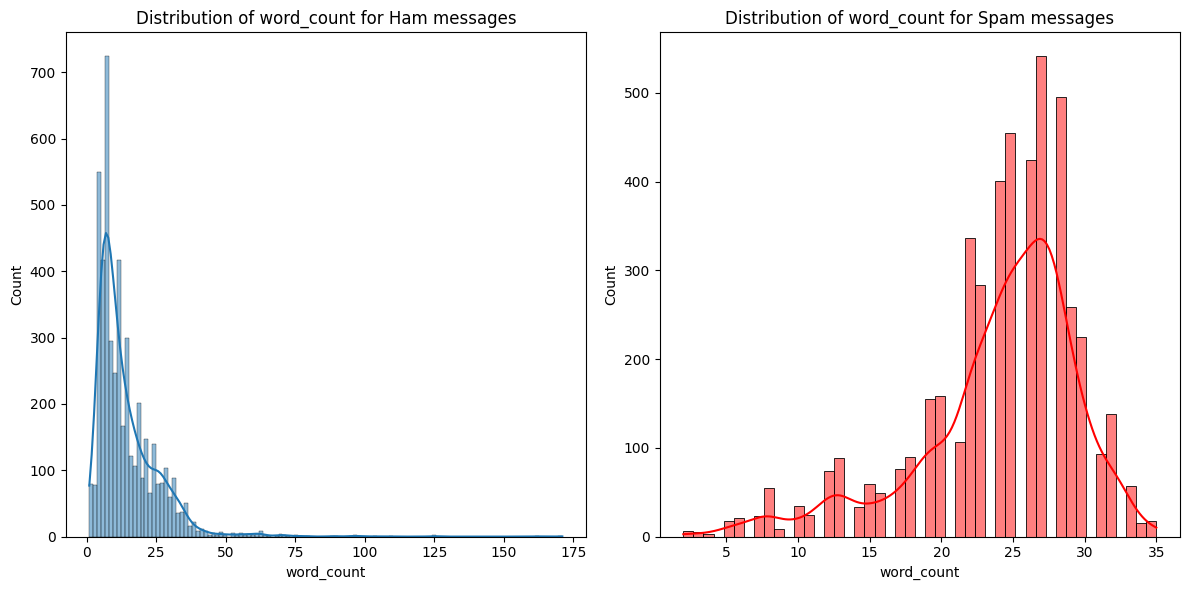

In [197]:
plt.figure(figsize=(12, 6))

# 1-row, 2-column, go to the first subplot
plt.subplot(1, 2, 1)
sns.histplot(df[df['label'] == 0].word_count, kde=True)
plt.title('Distribution of word_count for Ham messages')

# 1-row, 2-column, go to the second subplot
plt.subplot(1, 2, 2)
sns.histplot(df[df['label'] == 1].word_count, color='red', kde=True)
plt.title('Distribution of word_count for Spam messages')

plt.tight_layout()
plt.show()


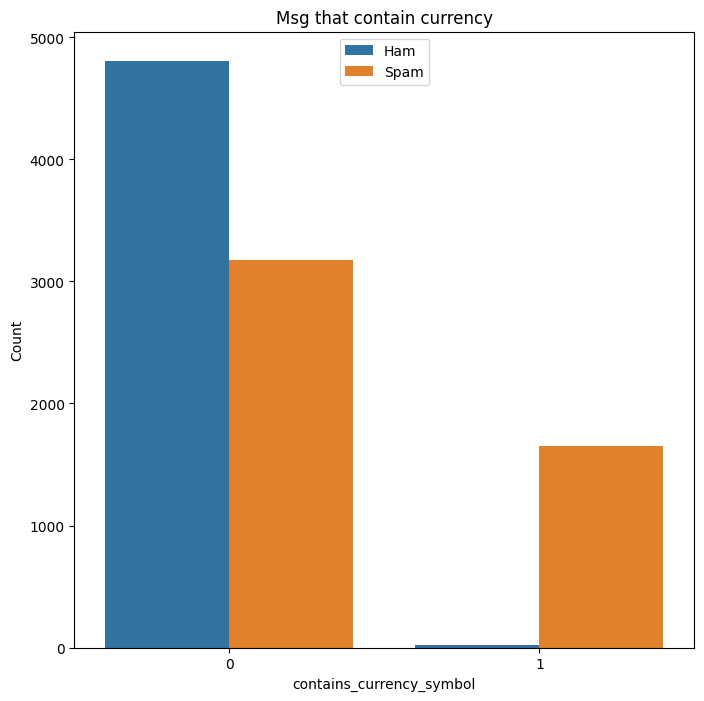

In [199]:
# Countplot for contains_currency_symbol
plt.figure(figsize=(8,8))
g = sns.countplot(x='contains_currency_symbol', data=df, hue='label')
p = plt.title('Msg that contain currency')
p = plt.ylabel('Count')
p = plt.legend(labels=['Ham', 'Spam'], loc=9)

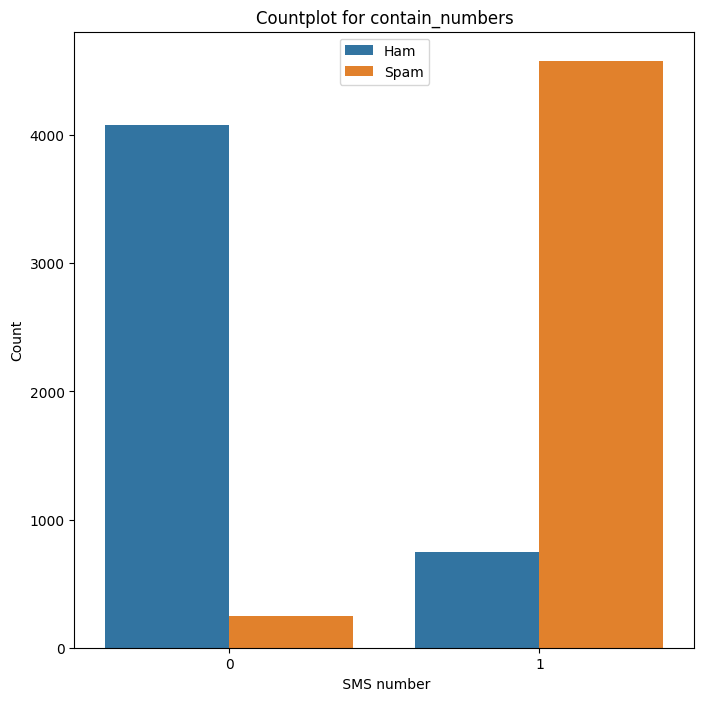

In [161]:
# Countplot for contains_number
plt.figure(figsize=(8,8))
g = sns.countplot(x='contains_number', data=df, hue='label')
p = plt.title('Countplot for contain_numbers')
p = plt.xlabel(' SMS number')
p = plt.ylabel('Count')
p = plt.legend(labels=['Ham', 'Spam'], loc=9)

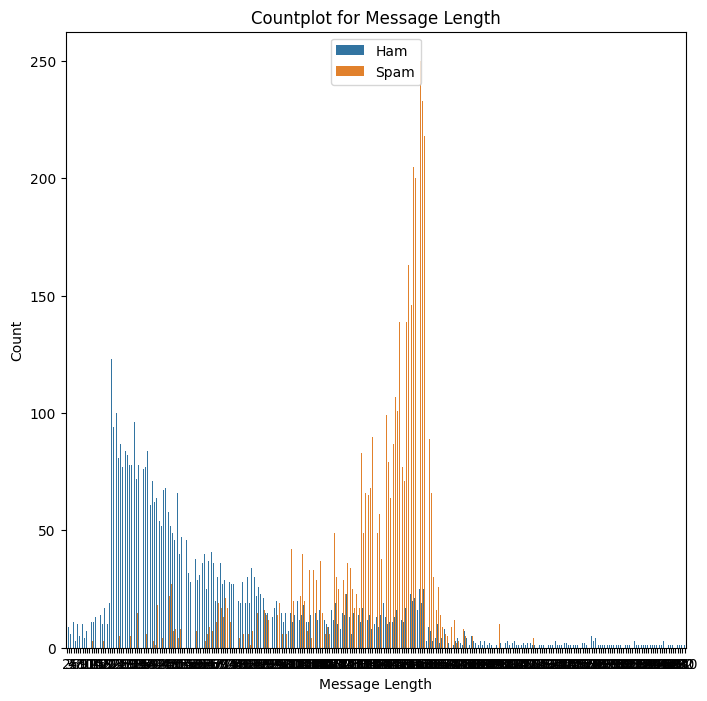

In [162]:
# Countplot for message length
plt.figure(figsize=(8,8))
g = sns.countplot(x='message_length', data=df, hue='label')
plt.title('Countplot for Message Length')
plt.xlabel('Message Length')
plt.ylabel('Count')
plt.legend(labels=['Ham', 'Spam'], loc=9)
plt.show()


# **Data Cleaning**


In [168]:
corpus = []
wnl = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

for sms_string in list(df.message):
    message = re.sub(pattern='[^a-zA-Z]', repl=' ', string=sms_string)  # Clean special chars
    message = message.lower()  # Convert to lowercase
    words = message.split()  # Tokenize
    filtered_words = [word for word in words if word not in stop_words and len(word) > 2]  # Remove stopwords and short words
    lemmatized_words = [wnl.lemmatize(word) for word in filtered_words]  # Lemmatize
    message = ' '.join(lemmatized_words)  # Rejoin lemmatized words
    corpus.append(message)  # Add to corpus

# Tfidf Vectorizer with improved features
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(max_features=500, ngram_range=(1, 2), max_df=0.9, min_df=5)
vectors = tfidf.fit_transform(corpus).toarray()

# Create DataFrame for features
feature_names = tfidf.get_feature_names_out()
X = pd.DataFrame(vectors, columns=feature_names)
y = df['label']



#Model


#Logistic Regression


--- Average Accuracy for Logistic Regression (with Cross-Validation): 0.989 ---
Standard Deviation: 0.004
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1462
           1       0.99      0.99      0.99      1433

    accuracy                           0.99      2895
   macro avg       0.99      0.99      0.99      2895
weighted avg       0.99      0.99      0.99      2895



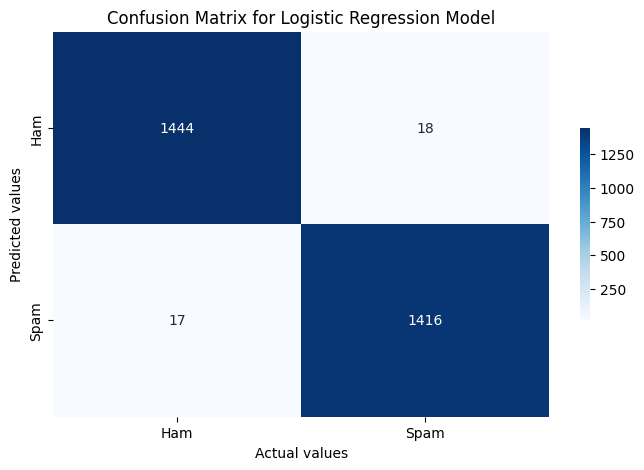

In [178]:
# Step 1: Preprocessing the data
# Split the data into features (X) and target (y)
X = df['message']  # Text data
y = df['label']  # Spam (1) or Ham (0)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Step 2: Convert text data into numerical features using TF-IDF Vectorizer
vectorizer = TfidfVectorizer(stop_words='english')  # Remove common stopwords
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Step 3: Train the Logistic Regression model
logreg = LogisticRegression(max_iter=1000)  # max_iter=1000 for convergence

# Perform cross-validation
cv_scores = cross_val_score(logreg, X_train_tfidf, y_train, cv=10, scoring='accuracy')  # 10-fold cross-validation
print(f"--- Average Accuracy for Logistic Regression (with Cross-Validation): {cv_scores.mean():.3f} ---")
print(f"Standard Deviation: {cv_scores.std():.3f}")

# Step 4: Train the model on the full training set after cross-validation
logreg.fit(X_train_tfidf, y_train)  # Train the model on the full training data

# Step 5: Make predictions
y_pred = logreg.predict(X_test_tfidf)

# Step 6: Evaluate the model
# Print classification report
print(classification_report(y_test, y_pred))

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix using Seaborn
plt.figure(figsize=(8, 5))
axis_labels = ['Ham', 'Spam']
sns.heatmap(data=cm, annot=True, cmap="Blues", xticklabels=axis_labels, yticklabels=axis_labels, fmt='g', cbar_kws={"shrink": 0.5})
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.title('Confusion Matrix for Logistic Regression Model')
plt.show()


#Decision Tree

--- Average Accuracy for Decision Tree (with Cross-Validation): 0.985 ---
Standard Deviation: 0.004
              precision    recall  f1-score   support

           0       1.00      0.97      0.98      1462
           1       0.97      1.00      0.98      1433

    accuracy                           0.98      2895
   macro avg       0.98      0.98      0.98      2895
weighted avg       0.98      0.98      0.98      2895



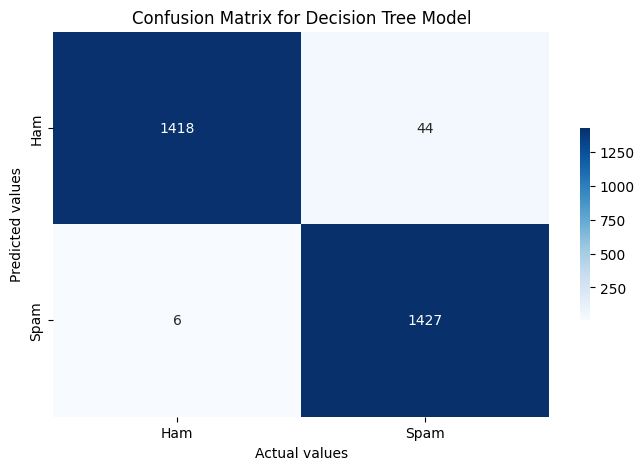

In [177]:
# Step 1: Preprocessing the data
# Split the data into features (X) and target (y)
X = df['message']  # Text data
y = df['label']  # Spam (1) or Ham (0)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Step 2: Convert text data into numerical features using TF-IDF Vectorizer
vectorizer = TfidfVectorizer(stop_words='english')  # Remove common stopwords
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Step 3: Train the Decision Tree model
dt = DecisionTreeClassifier(random_state=42)  # Initialize Decision Tree Classifier

# Perform cross-validation
cv_scores = cross_val_score(dt, X_train_tfidf, y_train, cv=10, scoring='accuracy')  # 10-fold cross-validation
print(f"--- Average Accuracy for Decision Tree (with Cross-Validation): {cv_scores.mean():.3f} ---")
print(f"Standard Deviation: {cv_scores.std():.3f}")

# Step 4: Train the model on the whole training set after cross-validation
dt.fit(X_train_tfidf, y_train)  # Train the model on the full training data

# Step 5: Make predictions
y_pred = dt.predict(X_test_tfidf)

# Step 6: Evaluate the model
# Print classification report
print(classification_report(y_test, y_pred))

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix using Seaborn
plt.figure(figsize=(8, 5))
axis_labels = ['Ham', 'Spam']
sns.heatmap(data=cm, annot=True, cmap="Blues", xticklabels=axis_labels, yticklabels=axis_labels, fmt='g', cbar_kws={"shrink": 0.5})
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.title('Confusion Matrix for Decision Tree Model')
plt.show()


#Random Forest

--- Average F1-Score for Random Forest (with Cross-Validation): 0.997 ---
Standard Deviation: 0.002
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1462
           1       1.00      1.00      1.00      1433

    accuracy                           1.00      2895
   macro avg       1.00      1.00      1.00      2895
weighted avg       1.00      1.00      1.00      2895



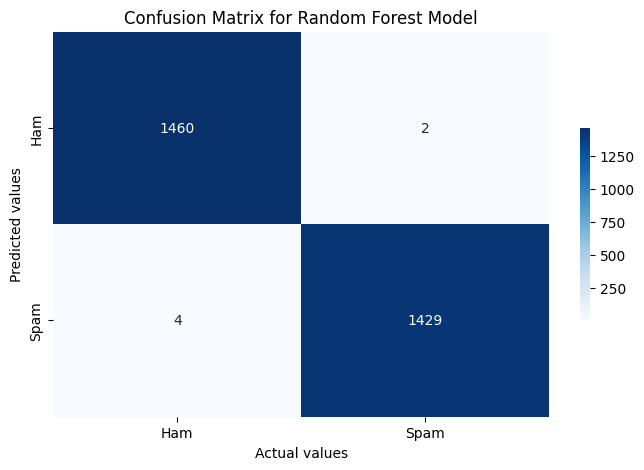

In [179]:
# Step 1: Preprocessing the data
# Split the data into features (X) and target (y)
X = df['message']  # Text data
y = df['label']  # Spam (1) or Ham (0)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Step 2: Convert text data into numerical features using TF-IDF Vectorizer
vectorizer = TfidfVectorizer(stop_words='english')  # Remove common stopwords
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Step 3: Train the Random Forest model
rf = RandomForestClassifier(n_estimators=10, random_state=42)  # Initialize Random Forest Classifier

# Perform cross-validation
cv_scores = cross_val_score(rf, X_train_tfidf, y_train, cv=10, scoring='f1')  # 10-fold cross-validation
print(f"--- Average F1-Score for Random Forest (with Cross-Validation): {cv_scores.mean():.3f} ---")
print(f"Standard Deviation: {cv_scores.std():.3f}")

# Step 4: Train the model on the whole training set after cross-validation
rf.fit(X_train_tfidf, y_train)  # Train the model on the full training data

# Step 5: Make predictions
y_pred = rf.predict(X_test_tfidf)

# Step 6: Evaluate the model
# Print classification report
print(classification_report(y_test, y_pred))

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix using Seaborn
plt.figure(figsize=(8, 5))
axis_labels = ['Ham', 'Spam']
sns.heatmap(data=cm, annot=True, cmap="Blues", xticklabels=axis_labels, yticklabels=axis_labels, fmt='g', cbar_kws={"shrink": 0.5})
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()


# **Making Predictions**

In [196]:
# Function to predict if a message is spam using Random Forest model
def predict_with_rf(message):
    # Transform the input message to the same feature space as the training data
    message_tfidf = vectorizer.transform([message])  # Use the same vectorizer
    prediction = rf.predict(message_tfidf)  # Predict using the trained Random Forest model
    return prediction[0]  # Return the prediction value (0 or 1)

sample_messages = [
    'Congratulations! You have won a $1000 gift card. Claim it now!',  # Spam
    'Hey, are we still on for dinner tonight?',  # Ham
    'Just wanted to check in and see how you’re doing.',  # Ham
    'It was great catching up today! Let’s do it again soon.',  # Ham
    'Came to think of it. I have never got a spam message before.',  # Ham
    'Hi, this is Mark from SuperGym. We’ve reserved your spot for tomorrow’s fitness session. Let us know if you can’t make it!',  # Ham (service-related)
    'Reminder: Your subscription to UltimateFitness is about to renew. Please reply with STOP if you wish to cancel.',  # Ham (service reminder)
    'Free trip to Hawaii just for answering a survey! Click here to claim your prize!',  # Spam
    'Your Amazon order has shipped. Expect delivery within 3-5 business days.',  # Ham (transactional)
    'Hello! I wanted to check if you received the recent shipment I sent. Let me know if everything is okay.',  # Ham (neutral)
    'Hey! Just finished a project and wanted to get your thoughts on it. Hope you’re doing well.',  # Ham (friendly)
    'Congratulations! You’ve been selected for a free gift. Respond with YES to claim!',  # Spam
    'Quick reminder: Your dentist appointment is tomorrow at 3 PM. Let us know if you need to reschedule.',  # Ham (service reminder)
]

# Testing each sample message and printing the result
for msg in sample_messages:
    prediction = predict_with_rf(msg)  # Get the prediction result
    if prediction == 1:  # If the model predicts SPAM
        print(f"SPAM: {msg}")
    else:  # If the model predicts HAM
        print(f"HAM: {msg}")


SPAM: Congratulations! You have won a $1000 gift card. Claim it now!
HAM: Hey, are we still on for dinner tonight?
HAM: Just wanted to check in and see how you’re doing.
HAM: It was great catching up today! Let’s do it again soon.
HAM: Came to think of it. I have never got a spam message before.
HAM: Hi, this is Mark from SuperGym. We’ve reserved your spot for tomorrow’s fitness session. Let us know if you can’t make it!
HAM: Reminder: Your subscription to UltimateFitness is about to renew. Please reply with STOP if you wish to cancel.
SPAM: Free trip to Hawaii just for answering a survey! Click here to claim your prize!
HAM: Your Amazon order has shipped. Expect delivery within 3-5 business days.
HAM: Hello! I wanted to check if you received the recent shipment I sent. Let me know if everything is okay.
HAM: Hey! Just finished a project and wanted to get your thoughts on it. Hope you’re doing well.
SPAM: Congratulations! You’ve been selected for a free gift. Respond with YES to claim!